# Load all .xml files 

In [10]:
import os
import string
import xml.etree.ElementTree as ET
import re

# Define the directory where you want to search for files
root_directory = '/common/datasets/cdip/'
text_root_directory = "texts"
images_root_directory = "images"

In [ ]:
available_text_data = []

for letter1 in string.ascii_lowercase:
    for letter2 in string.ascii_lowercase:
        filename = f"iitcdip.{letter1}.{letter2}.xml"  # Modify the filename pattern as needed
        file_path = os.path.join(root_directory, text_root_directory, filename)
        if os.path.exists(file_path):
            print(f"File '{file_path}' exists.")
            available_text_data.append(file_path)
        else:
            print(f"File '{file_path}' does not exist.")

In [ ]:
import os
import xml.etree.ElementTree as ET
import re
from tqdm import tqdm 

# Create a list to store the extracted data from each XML file
extracted_data_list = []
        
# Function to extract data from an XML file
def extract_data_from_xml(xml_file_path, root_directory, images_root_directory):
    try:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        # Find all <record> elements in the XML
        records = root.findall(".//record")
        for record in records:
            # Extract the file name from the <docid> element
            docid_element = record.find(".//docid")
            docid = docid_element.text.strip() if docid_element is not None else ""

            # Check if any of the required elements is missing
            missing_elements = [element for element in ['path', 'dt', 'tid', 'ot'] if record.find(f'.//{element}') is None]
            if missing_elements:
                print(f"Ignoring {docid} file: Missing the following required elements: {', '.join(missing_elements)}")
                continue

            # Extract the file path from the <path> element
            docpath_element = record.find('.//path').text.strip()
            head, tail = os.path.split(os.path.split(os.path.join(root_directory, images_root_directory, docpath_element))[0])
            images_path = os.path.join(head, tail)
            
            if not os.path.exists(images_path) or not os.path.isdir(images_path):
                print(f"The directory '{images_path}' does not exist.")
                continue

            #print(f"The directory '{images_path}' exists.")
            tif_images = [os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith('.tif')]
            
            # Create a dictionary to store the extracted information
            extracted_data = {
                'File ID': record.find('.//tid').text.strip(),
                'Image Path' : tif_images,
                'Doc category': record.find('.//dt').text.strip() if record.find('.//dt').text.strip() is not None else None,
                'Key': record.find('.//K').text.strip() if record.find('.//K') is not None else None, 
                'Title': record.find('.//K').text.strip() if record.find('.//ti') is not None else None
            }
                
            # Find the 'ot' element and extract the text if it exists
            ot_element = record.find('.//ot')
            if ot_element is not None:
                ot_text = ot_element.text.strip()
                separated_lines = ot_text.split('\n')

                # Initialize variables to track the current content and PgNbr
                text_to_page_dict = {}
                page_to_text_dict = {}
                current_content = ""
                current_pgnbr = None
                page_count = 0  # Initialize a counter for page numbers

                # Process each line
                for line in separated_lines:
                    # Check if the line starts with "Page" followed by a number
                    if line.startswith("pgNbr="):
                        # If yes, it's a PgNbr line
                        current_pgnbr = int(re.search(r'pgNbr=(\d+)', line).group(1))
                        page_count += 1  # Increment the page count
                        if current_content:
                            pg_text_key = f"PgNbr {current_pgnbr}"  # Create PgText key
                            page_to_text_dict[current_pgnbr] = current_content  # Map PgNbr to content
                            text_to_page_dict[pg_text_key] = current_content  # Map PgText to PgNbr
                        current_content = ""  # Reset content
                    else:
                        # Otherwise, it's a content line
                        current_content += line  # Append to current content

                # Add the last content
                if current_content:
                    pg_text_key = f"PgNbr {current_pgnbr}"  # Create PgText key
                    page_to_text_dict[current_pgnbr] = current_content  # Map PgNbr to content
                    text_to_page_dict[pg_text_key] = current_content  # Map PgText to PgNbr

                # Add the total page number count to the text_to_page_dict
                text_to_page_dict["Total PgNbr"] = page_count

                extracted_data.update(text_to_page_dict)
            
            extracted_data_list.append(extracted_data)

    except Exception as e:
        print(f"Error parsing XML file {xml_file_path}: {str(e)}")

# Iterate through the directories and files
for xml_files in tqdm(available_text_data):
    xml_file_path = os.path.join(root_directory, xml_files)     
    if os.path.exists(xml_file_path):
        extract_data_from_xml(xml_file_path, root_directory, images_root_directory)
    else:
        print(f"XML file '{xml_file_path}' does not exist.")

In [14]:
len(extracted_data_list)

5687230

In [29]:
# only keep the document having length = 1 
cdip_document_pages = []

for sample_data in cdip_data:
    image_path = sample_data.get('Image Path')
    total_pages = sample_data.get('Total PgNbr')

    if image_path is not None and total_pages is not None:
        if len(image_path) == total_pages and len(image_path) == 1:
            cdip_document_pages.append(sample_data)

In [39]:
len(cdip_document_pages)

3062493

In [32]:
# only keep documents having no words > 128 
cdip_document_pages_128 = []

for entry in cdip_document_pages:
    text_entry = entry.get("PgNbr 1")  # Get the value of "PgNbr 1" field
    if text_entry is not None:
        words = text_entry.split()
        if len(words) > 128:  # Check the word count, not the length of the text
            cdip_document_pages_128.append(entry)

In [33]:
len(cdip_document_pages_128)

1284554

In [35]:
import numpy as np 
cdip_data = np.array(cdip_document_pages_128)
np.save("cdip_signle_page_dataset.npy", cdip_data)

# Load the dataset

In [4]:
import pandas as pd
import numpy as np
import re

In [5]:
def load_cdip_dataset(data_path):
    # Load the dataset
    cdip_single_page_data = np.load(data_path, allow_pickle=True)
    
    # Extract image paths and text entries
    image_entry = [entry.get('Image Path')[0] for entry in cdip_single_page_data]
    text_entry = [entry.get('PgNbr 1') for entry in cdip_single_page_data]
    type_entry = [entry.get('Doc category') for entry in cdip_single_page_data]
    key_entry = [entry.get('Key') for entry in cdip_single_page_data]
    title_entry = [entry.get('Title') for entry in cdip_single_page_data]
    
    # Create a pandas DataFrame
    cdip_data = pd.DataFrame({
        'image_path': image_entry,
        'text': text_entry, 
        'type': type_entry,
        'key': key_entry, 
        'title': title_entry
    })
    
    return cdip_data

In [6]:
df = load_cdip_dataset('cdip_signle_page_dataset.npy')
df.head()

image_path  \
0  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
1  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
2  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
3  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
4  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   

                                                text                    type  \
0  MeE. MORANDIIM\t\tiixa2enm~[ivr'~V ~cuewA\t\to...                    Memo   
1  PROFS note for HREIF 3 Mar 1993 07:40 Page 1 o...             TELE, TELEX   
2  -7IMEFENABNANGE GregMoure(LEFT) and GiI de Fer...  MAGA, MAGAZINE ARTICLE   
3  CUNNINGHAM &amp; WALSH CHICAGO, INC.875 NOR1H ...                    FORM   
4  IN'BIFO Institut fi)r biologische Forschung  K...              FORM, FORM   

                                                 key  \
0  Carlton Filter 30-Sheet Posters (New Design), ...   
1                               PHONE CALL W/ LISTER   
2                               PENSKE SERVES NOTICE   
3                                     -- No Title --   
4   GENERAL OBJECTIVES AND SPECIFICATIONS P0500/5209   

                                               title  
0  Carlton Filter 30-Sheet Posters (New Design), ...  
1                               PHONE CALL W/ LISTER  
2                               PENSKE SERVES NOTICE  
3                                     -- No Title --  
4   GENERAL OBJECTIVES AND SPECIFICATIONS P0500/5209

# Preprocessing Text

In [8]:
from tqdm import tqdm

tqdm.pandas()

In [11]:
def preprocess_text(text):
    if text is not None:
        text = str(text)

        # Replace extra whitespace characters with a single space
        text = re.sub(r"\s+", " ", text)
        
        # Handle special characters: remove except letters & numbers
        text = re.sub(r"[^a-zA-Z0-9?.!,: ]",r"", text)
        text = re.sub(r"([?.!,:])", r"\1 ", text)

        # Remove extra whitespace
        text = ' '.join(text.split()).strip()
    
    return text

In [12]:
df[(df['key'] != df['title']) & df['key'].notna()].shape

(53, 5)

In [13]:
df[(df['key'] != df['title']) & df['title'].notna()].shape

(0, 5)

In [14]:
df[df.key.isna()].shape

(165093, 5)

In [93]:
df[df.title.isna()].shape

(165146, 5)

In [16]:
# only use key value bcz almost key & title is the same
# for the different, only key elements has value
df['text'] = df['text'].progress_apply(preprocess_text)
df['key'] = df['key'].progress_apply(preprocess_text)

  0%|          | 0/1284554 [00:00<?, ?it/s]

100%|██████████| 1284554/1284554 [00:08<00:00, 151930.88it/s]


# Key, Title

In [17]:
df['key'] = df['key'].progress_apply(lambda x: x.lower() if pd.notna(x) else x)

100%|██████████| 1284554/1284554 [00:01<00:00, 1019761.51it/s]


In [18]:
df[df.key.isna()].shape

(165093, 5)

In [19]:
df.key.value_counts().head(50)

key
no title                                                           41136
untitled                                                            4458
facsimile transmission                                              2477
currently active grants, contracts and other sources of funds       2197
fax cover                                                           1852
certificate of insurance                                            1778
n403                                                                1739
document disposal suspension notice                                 1699
request for production of consumer test cigarettes                  1591
r107                                                                1584
active records disposal notice                                      1569
outdoor bulletin display contract                                   1383
fax cover sheet                                                     1305
n344                                           

In [20]:
df.key[df['key'].str.contains('title', na=False)].value_counts().head(50)

key
no title                                                                                                                                                                                                                                         41136
untitled                                                                                                                                                                                                                                          4458
untitled.                                                                                                                                                                                                                                           36
untitled attachment.                                                                                                                                                                                                                                27
grant en

In [21]:
df.key[df['key'].str.contains('no', na=False)].value_counts().head(50)

key
no title                                                                                                                                                                          41136
document disposal suspension notice                                                                                                                                                1699
active records disposal notice                                                                                                                                                     1569
no ttl                                                                                                                                                                              940
group and individual inlife observations project no. : b 3276                                                                                                                       522
smoking should not be a part of growing up                                  

In [22]:
# replace value for a column 
def replace(df, column, old, new):
    df[column] = df[column].apply(lambda x: x.replace(old, new) if isinstance(x, str) else x)
    return df

In [23]:
df.replace('no title', None, inplace=True)
df.replace('untitled', None, inplace=True)
df.replace('no ttl', None, inplace=True)
df.replace('untitled .', None, inplace=True)
df.replace('untitled attachment .', None, inplace=True)

In [24]:
df[df.key.isna()].shape

(211627, 5)

In [25]:
df.key.value_counts()

key
facsimile transmission                                                                                                 2477
currently active grants, contracts and other sources of funds                                                          2197
fax cover                                                                                                              1852
certificate of insurance                                                                                               1778
n403                                                                                                                   1739
                                                                                                                       ... 
study rationale                                                                                                           1
notice of board action on violation case no. 1n1139a                                                                      1
once

# Type

In [26]:
def normalize(text): 
    text = text.lower()
    # change all punctuation to ','
    text = re.sub(r'[^\w\s,-]', ',', text)
    return text

In [27]:
df['type'] = df['type'].progress_apply(normalize)

100%|██████████| 1284554/1284554 [00:01<00:00, 701187.16it/s]


In [28]:
df.type.value_counts().head(50)

type
letter                                  173069
lett, letter                            112913
memo, memorandum                        101796
form, form                               77801
memo                                     48456
spec, specification                      46469
rept, report, other                      44369
emai, e-mail                             37606
report                                   36345
tele, telex                              33021
news, news article                       28086
published doc                            21936
news, newspaper article                  14603
abstract                                 14228
comp, computer printout                  13731
char, chart, graph, table, maps          13490
scientific article                       12851
scrt, report, scientific                 12810
media articles,media transcripts         11990
rept, other report                       11941
form                                     11727
advertis

In [29]:
from collections import Counter

# load all types in a list 
t = df.type.unique()
l = [len(re.split(',', i)) for i in t]

# no_documents having a specific number of types
Counter(l)

Counter({2: 1170,
         3: 824,
         4: 456,
         1: 310,
         5: 128,
         6: 103,
         7: 57,
         9: 7,
         8: 4,
         10: 2})

In [30]:
# Remove substrings/duplicated from a comma-separated text
def remove_substrings(text, d):
    text = text.lower()
    elements = text.split(d) # ','
    unique_elements = list(set(elements))  # remove duplicates
    result = []
    for element in unique_elements:
        is_substring = False
        for other in unique_elements:
            if element!= other and element in other:
                is_substring = True
                break
        if not is_substring:
            result.append(element.strip())
    return d.join(result) # ', '

In [31]:
result = [text for text in t]
result

['memo',
 'tele, telex',
 'maga, magazine article',
 'form',
 'form, form',
 'lett, letter',
 'scientific article',
 'abstract',
 'rept, report, other',
 'email, letter',
 'news, news article',
 'invo, invoice',
 'e-mail',
 'memo, memo',
 'spec, specification',
 'memo, memorandum',
 'memorandum',
 'financial',
 'manuals,procedures,instructions,guidelines',
 'cont, contract, agreement resolution',
 'letter',
 'note',
 'other',
 'prom, promotional material',
 'scrt, report, scientific',
 'media articles,media transcripts',
 'budget review',
 'published doc',
 'psci, scientific publication',
 'budg, budget,budget review',
 'report',
 'list',
 'report,study',
 'consumer response letter',
 'char, chart, graph, table, maps',
 'smoke,tobacco analysis',
 'news, newspaper article',
 'scrt,',
 'adve, advertisement',
 'minutes',
 'pamp, pamphlet',
 'progress report',
 'manu, manual, handbook, catalogue',
 'application for grant',
 'consumer letter',
 'pres, press release',
 'radio , television co

In [32]:
r1 = [remove_substrings(text, ',') for text in result]
r2 = [remove_substrings(text, ' ') for text in r1]
r2 

['memo',
 'telex',
 'article magazine',
 'form',
 'form',
 'letter',
 'article scientific',
 'abstract',
 'other,rept,report',
 'email,letter',
 'article news',
 'invoice',
 'e-mail',
 'memo',
 'specification',
 'memorandum',
 'memorandum',
 'financial',
 'procedures,guidelines,manuals,instructions',
 'agreement resolution,contract',
 'letter',
 'note',
 'other',
 'promotional material',
 'scrt,report,scientific',
 'articles transcripts,media',
 'review budget',
 'published doc',
 'publication psci,scientific',
 'review,budget',
 'report',
 'list',
 'study,report',
 'letter consumer response',
 'graph,table,maps,chart',
 'analysis,smoke tobacco',
 'article newspaper',
 'scrt',
 'advertisement',
 'minutes',
 'pamphlet',
 'report progress',
 'catalogue,manual,handbook',
 'for application grant',
 'letter consumer',
 'press release',
 'commercials radio,television',
 'request invoice,pay',
 'scientific report',
 'collage',
 'other,publication',
 'note',
 'review budget',
 'e-mail,emai',
 

In [33]:
l = [len(i.split(',')) for i in r2]
Counter(l)

Counter({2: 1304, 3: 918, 1: 414, 4: 305, 5: 93, 6: 22, 7: 5})

In [34]:
df['type'] = df['type'].progress_apply(lambda x: remove_substrings(x, ','))
df['type'] = df['type'].progress_apply(lambda x: remove_substrings(x, ' '))
df.type

100%|██████████| 1284554/1284554 [00:01<00:00, 803161.18it/s]


0                            memo
1                           telex
2                article magazine
3                            form
4                            form
                    ...          
1284549    site,wsit web internet
1284550                    letter
1284551                      form
1284552                    agenda
1284553             review budget
Name: type, Length: 1284554, dtype: object

In [35]:
df.type.value_counts()

type
letter                      286172
memorandum                  111580
form                         89631
memo                         55068
specification                48523
                             ...  
bibliography,memo                1
other,publication,resume         1
schedule                         1
outline,minutes                  1
agenda,email,draft               1
Name: count, Length: 2344, dtype: int64

# Draft

In [101]:
df['type'] = df['type'].progress_apply(lambda x: remove_substrings(x, ','))
df['type'] = df['type'].progress_apply(lambda x: remove_substrings(x, ' '))
df.type.value_counts()

100%|██████████| 1284554/1284554 [00:01<00:00, 831623.49it/s]


type
letter        303247
memo          168704
report        122902
form           98822
news           73975
               ...  
receipt            1
schedule           1
lpro               1
message            1
marginalia         1
Name: count, Length: 196, dtype: int64

In [37]:
df.type.replace('e-mail', 'email', inplace=True)
df.type.replace('memorandum', 'memo', inplace=True)
df.type.replace('rept', 'report', inplace=True)
df.type.replace('budgetet', 'budget', inplace=True)
df.type.replace('budg', 'budget', inplace=True)
df.type.replace('regl', 'regulation', inplace=True)
df.type.replace('zflb', 'folder', inplace=True)

/tmp/ipykernel_2685257/1732591692.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.type.replace('e-mail', 'email', inplace=True)
/tmp/ipykernel_2685257/1732591692.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [38]:
l = [len(i.split(',')) for i in df['type']]
Counter(l)

Counter({1: 974010, 2: 215656, 3: 75585, 4: 18972, 5: 267, 6: 58, 7: 6})

In [39]:
# if types of a documents contains those types, change types of this type 
# purpose: avoid one document having multiple types 
types = ['email', 'memo', 'letter', 'advertise', 'form', 'news', 'note', 'hand', 'report', 'resume', 'scientific', 'article', 'pub', 'adv', 'budget', 'chart']
for substring in types:
    df['type'] = np.where(df['type'].str.contains(substring), substring, df['type'])

In [40]:
df.type.replace('adv', 'advertise', inplace=True)
df.type.replace('pub', 'publication', inplace=True)
df.type.replace('hand', 'handwritten', inplace=True)

/tmp/ipykernel_2685257/1315782399.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.type.replace('adv', 'advertise', inplace=True)
/tmp/ipykernel_2685257/1315782399.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [41]:
types = ['analysis', 'financial','printout', 'abstract', 'guidelines', 'press', 'invoice', 'agenda', 'contract', 'telex', 'presentation', 'transcript', 'promotional', 'collage', 'calendar', 'fax', 'proposal', 'specification', 'script', 'folder', 'list', 'draft', 'regulation', 'legislation', 'law', 'graphic', 'packages', 'protocol', 'review', 'bibliography', 'grant', 'plan', 'record', 'calculations', 'questionnaire']
for substring in types:
    df['type'] = np.where(df['type'].str.contains(substring), substring, df['type'])

In [43]:
df.type.replace('press', 'release press', inplace=True)

/tmp/ipykernel_2685257/2866582961.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.type.replace('press', 'release press', inplace=True)


In [44]:
types = ['e-mail', 'patent application', 'statement', 'site web', 'television commercials', 'manual', 'excerpt', 'statistics', 'booklet']
for substring in types:
    df['type'] = np.where(df['type'].str.contains(substring), substring, df['type'])

In [45]:
df.type.replace('brochure', 'booklet', inplace=True)
df.type.replace('pamphlet', 'booklet', inplace=True)

/tmp/ipykernel_2685257/3642381686.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.type.replace('brochure', 'booklet', inplace=True)
/tmp/ipykernel_2685257/3642381686.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [46]:
df.type.replace('"tabs,document dividers"', 'folder', inplace=True)

/tmp/ipykernel_2685257/4060635483.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.type.replace('"tabs,document dividers"', 'folder', inplace=True)


In [47]:
df.type.iloc[1110707]

'blank page'

In [48]:
types = ['cover', 'page', 'application', 'legislative', 'attachment', 'drawing', 'video', 'personnel info', 'exhibit']
for substring in types:
    df['type'] = np.where(df['type'].str.contains(substring), substring, df['type'])

In [49]:
df.type.replace('e-mail', 'email', inplace=True)
df.type.replace('brochure,pamphlet', 'booklet', inplace=True)
df.type.replace('consumer,revision le response', 'consumer le response', inplace=True)
df.type.replace('revision le,consumer response', 'consumer le response', inplace=True)

/tmp/ipykernel_2685257/1278758084.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.type.replace('e-mail', 'email', inplace=True)
/tmp/ipykernel_2685257/1278758084.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [50]:
types = ['decisions', 'page', 'application', 'legislative', 'attachment', 'drawing', 'video', 'personnel info', 'exhibit', 'revision', 'minutes','affidavit']
for substring in types:
    df['type'] = np.where(df['type'].str.contains(substring), substring, df['type'])

In [51]:
df.type.iloc[809950] = 'statistics'
df.type.iloc[226701] = 'legal document'
df.type.replace('legal document', 'legal documents', inplace=True)
df.type.iloc[138470] = 'proposal' 
df.type.iloc[46390] = 'folder'
# df.type.iloc[46390] = 'promotional'
df.type.iloc[1169550] = 'agreement'

/tmp/ipykernel_2685257/2534012158.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.type.iloc[809950] = 'statistics'
/tmp/ipykernel_2685257/2534012158.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You

In [52]:
df.type.iloc[195200] = 'article'
df.type.iloc[39977] = 'list'
df.type.iloc[997230] = 'form'
df.type.iloc[1040266] = 'form'
df.type.iloc[842126] = 'list'
df.type.replace('patent,internet', 'patent', inplace=True)
df.type.iloc[1196860] = 'statement'
df.type.iloc[1129694] = 'speech'

/tmp/ipykernel_2685257/3084278327.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.type.iloc[195200] = 'article'
/tmp/ipykernel_2685257/3084278327.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You ar

In [53]:
df.type.iloc[791099] = 'legal documents'

/tmp/ipykernel_2685257/1629005655.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.type.iloc[791099] = 'legal documents'


In [64]:
types = ['delivery slip', 'site', 'receiving', 'commercials radio', 'attachment', 'drawing', 'video', 'personnel info', 'exhibit', 'revision', 'minutes','affidavit']
for substring in types:
    df['type'] = np.where(df['type'].str.contains(substring), substring, df['type'])

In [65]:
df.type.iloc[71960] = 'booklet'
df.type.iloc[158427] = 'regulation'
df.type.iloc[403135] = 'report'
df.type.iloc[816762] = 'manual'
df.type.iloc[1045208] = 'proposal'

/tmp/ipykernel_2685257/716099326.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.type.iloc[71960] = 'booklet'
/tmp/ipykernel_2685257/716099326.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are s

In [75]:
df.type.replace('info,internet personnel', 'personnel info', inplace=True)
df.type.replace('internet,patent', 'patent', inplace=True)

In [76]:
l = [len(i.split(',')) for i in df.type]
Counter(l)

Counter({1: 1284554})

In [77]:
df.type.iloc[np.where(np.array(l) == 2)].value_counts()

Series([], Name: count, dtype: int64)

In [78]:
df.type.iloc[1196860]

'statement'

In [79]:
df.type

0             memo
1            telex
2          article
3             form
4             form
            ...   
1284549       site
1284550     letter
1284551       form
1284552     agenda
1284553     budget
Name: type, Length: 1284554, dtype: object

In [84]:
df.type.unique()

array(['memo', 'telex', 'article', 'form', 'letter', 'scientific',
       'abstract', 'report', 'email', 'news', 'invoice', 'specification',
       'financial', 'guidelines', 'contract', 'note', 'other',
       'promotional', 'budget', 'publication', 'list', 'chart',
       'analysis', 'scrt', 'advertise', 'minutes', 'booklet',
       'handwritten', 'grant', 'release press', 'commercials radio',
       'collage', 'proposal', 'protocol', 'graphic', 'printout', 'script',
       'delivery slip', 'application', 'questionnaire', 'routing slip',
       'site', 'review', 'manual', 'regulation', 'fax',
       'shipping documents', 'resume', 'patent', 'agenda', 'legislation',
       'speech', 'appendix', 'le consumer response', 'agreement',
       'research marketing', 'redbook', 'law', 'plan', 'pleading',
       'presentation', 'legal', 'transmittal', 'excerpt', 'request work',
       'folder', 'receiving', 'affidavit', 'doc marketing', 'outline',
       'drawing', 'statement', 'personnel info

In [100]:
df.type.replace('paap', 'invention record', inplace=True)
df.type.replace('advertise', 'advertisement', inplace=True)
df.type.replace('lab', 'laboratory', inplace=True)
df.type.replace('pleadings', 'pleading', inplace=True)
df.type.replace('patents', 'patent', inplace=True)
df.type.replace('catalog cards', 'catalog card', inplace=True)
df.type.replace('facsimile', 'fax', inplace=True)
df.type.replace('fascimile', 'fax', inplace=True)
df.type.replace('lett', 'letter', inplace=True)

In [93]:
df.type.iloc[161944]

'memo'

In [104]:
df.type.replace('ltr', 'letter', inplace=True)
df.type.replace('msg', 'message', inplace=True)
df.type.replace('receipt', 'invoice', inplace=True)

/tmp/ipykernel_2685257/614602820.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.type.replace('ltr', 'letter', inplace=True)
/tmp/ipykernel_2685257/614602820.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [109]:
df.type.iloc[554994] = 'handwritten'
df.type.iloc[533533] = 'report'
df.type.iloc[660544] = 'analysis'
df.type.iloc[1062116] = 'memo'

In [111]:
df.type.replace('hri', 'personnel info', inplace=True)
df.type.replace('log', 'shipping documents', inplace=True)
df.type.replace('ship', 'shipping documents', inplace=True)
df.type.replace('invo', 'invoice', inplace=True)
df.type.replace('spch', 'speech', inplace=True)

In [167]:
df['type'] = df['type'].progress_apply(lambda x: remove_substrings(x, ','))
df['type'] = df['type'].progress_apply(lambda x: remove_substrings(x, ' '))
df.type.value_counts()

100%|██████████| 1284554/1284554 [00:01<00:00, 840935.52it/s]


type
letter             303251
memo               168705
report             122903
form                98822
news                73975
                    ...  
computer                1
analyst contact         1
acce                    1
orch                    1
marginalia              1
Name: count, Length: 172, dtype: int64

In [115]:
df.type.value_counts().tail(50)

type
spec                    7
summary                 7
index                   7
decisions               7
video                   6
invention record        6
disk computer           6
cim                     5
abst                    5
packaging               5
manu                    4
cards business          4
catalog card library    4
resolution              4
periodical              4
qrr                     4
ending sheet of file    3
binder                  3
cnt                     3
insurance               3
phot                    3
agen                    3
bid                     3
electronic media        3
motion                  3
per                     2
messages telephone      2
certificate stock       2
tax                     2
interrogatories         2
medical                 2
maga                    2
pr                      2
invo                    2
spch                    2
art-p                   2
ship                    2
laboratory              2
orch   

In [145]:
def find_containing_words(words, specific_word):
    # Use a set to avoid duplicates
    containing_words = {word for word in words if (specific_word in word and specific_word!=word)}
    if len(containing_words) != 0: 
        print(f"Word: {specific_word}")
        print("Containing Words:")
        for word in sorted(containing_words):
            print(word)

In [159]:
df[df.type=='spec']

image_path  \
844059   /common/datasets/cdip/images/imagesq/q/m/i/qmi...   
896226   /common/datasets/cdip/images/imagesr/r/m/i/rmi...   
923218   /common/datasets/cdip/images/imagest/t/a/i/tai...   
947539   /common/datasets/cdip/images/imagest/t/m/i/tmi...   
974158   /common/datasets/cdip/images/imagesu/u/a/i/uai...   
1024701  /common/datasets/cdip/images/imagesv/v/a/i/vai...   
1073822  /common/datasets/cdip/images/imagesw/w/a/i/wai...   

                                                      text  type  \
844059   All Manufacturing andProcessing Locations. Ori...  spec   
896226   PHILIP MORRIS JJU. S. A. TOBACCO PRODUCT STAND...  spec   
923218   All Manufacturing andProcessing LocationsrST z...  spec   
947539   PHILIP MORRIS ifU. S. A. TOBACCO PRODUCT STAND...  spec   
974158   1JPHILIP MORRIS Ifiu. s. A. TOBACCO PRODUCT ST...  spec   
1024701  PHILIP MORRIS Ifiu. s. A. TOBACCO PRODUCT STAN...  spec   
1073822  PMPHILIP MORRIS U. S. A. TOBACCO PRODUCT STAND...  spec   

                               key                      title  
844059   tobacco product standards  TOBACCO PRODUCT STANDARDS  
896226   tobacco product standards  TOBACCO PRODUCT STANDARDS  
923218   tobacco product standards  TOBACCO PRODUCT STANDARDS  
947539   tobacco product standards  TOBACCO PRODUCT STANDARDS  
974158   tobacco product standards  TOBACCO PRODUCT STANDARDS  
1024701  tobacco product standards  TOBACCO PRODUCT STANDARDS  
1073822  tobacco product standards  TOBACCO PRODUCT STANDARDS

In [165]:
df.type.replace('phot', 'photograph', inplace=True)
df.type.replace('legal', 'legal documents', inplace=True)
df.type.replace('tele', 'telex', inplace=True)
df.type.replace('tran', 'transcript', inplace=True)
df.type.replace('abst', 'abstract', inplace=True)
df.type.replace('char', 'chart', inplace=True)
df.type.replace('pr', 'prs', inplace=True)
df.type.replace('ques', 'questionnaire', inplace=True)
df.type.replace('questionaire', 'questionnaire', inplace=True)
df.type.replace('agen', 'agenda', inplace=True)
df.type.replace('messages telephone', 'message telephone', inplace=True)
df.type.replace('graph', 'graphic', inplace=True)
df.type.replace('manu', 'manual', inplace=True)
df.type.replace('per', 'personnel info', inplace=True)
df.type.replace('maga', 'magazine', inplace=True)
df.type.replace('ship', 'shipping documents', inplace=True)
df.type.replace('invo', 'invoice', inplace=True)

/tmp/ipykernel_2685257/200419624.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.type.replace('phot', 'photograph', inplace=True)
/tmp/ipykernel_2685257/200419624.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [166]:
t = [i for i in df.type.unique()]
for i in tqdm(t):
    find_containing_words(t, i)

100%|██████████| 172/172 [00:00<00:00, 139001.98it/s]

Word: other
Containing Words:
media other
Word: script
Containing Words:
transcript
Word: patent
Containing Words:
full patent
Word: certificate
Containing Words:
certificate stock
Word: record
Containing Words:
invention record
Word: testimony
Containing Words:
testimony congressional
Word: catalog card
Containing Words:
catalog card library
Word: media
Containing Words:
electronic media
media other
Word: packaging
Containing Words:
labels and packaging
Word: personnel
Containing Words:
personnel files
personnel info
Word: motion
Containing Words:
promotional
Word: comp
Containing Words:
computer
disk computer
Word: test
Containing Words:
testimony
testimony congressional
Word: order
Containing Words:
order purchase
Word: message
Containing Words:
message points
message telephone
Word: computer
Containing Words:
disk computer
Word: spec
Containing Words:
specification


In [171]:
df.head()

image_path  \
0  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
1  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
2  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
3  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
4  /common/datasets/cdip/images/imagesa/a/a/a/aaa...   

                                                text     type  \
0  MeE. MORANDIIM iixa2enmivrV cuewA os. ms. eaum...     memo   
1  PROFS note for HREIF 3 Mar 1993 07: 40 Page 1 ...    telex   
2  7IMEFENABNANGE GregMoureLEFT and GiI de Ferran...  article   
3  CUNNINGHAM amp WALSH CHICAGO, INC. 875 NOR1H M...     form   
4  INBIFO Institut fir biologische Forschung KOIn...     form   

                                                 key  \
0  carlton filter 30sheet posters new design, mar...   
1                                phone call w lister   
2                               penske serves notice   
3                                               None   
4    general objectives and specifications p05005209   

                                               title  
0  Carlton Filter 30-Sheet Posters (New Design), ...  
1                               PHONE CALL W/ LISTER  
2                               PENSKE SERVES NOTICE  
3                                     -- No Title --  
4   GENERAL OBJECTIVES AND SPECIFICATIONS P0500/5209

In [175]:
df = df.drop('title', axis=1)

In [176]:
df.columns

Index(['image_path', 'text', 'type', 'key'], dtype='object')

# Visualize

In [24]:
import pandas as pd 

df = pd.read_csv('preprocessed_cdip.csv', index_col=0)
df = df.where(pd.notnull(df), None)
df

image_path  \
0        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
1        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
2        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
3        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
4        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
...                                                    ...   
1284549  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   
1284550  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   
1284551  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   
1284552  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   
1284553  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   

                                                      text     type  \
0        MeE. MORANDIIM iixa2enmivrV cuewA os. ms. eaum...     memo   
1        PROFS note for HREIF 3 Mar 1993 07: 40 Page 1 ...    telex   
2        7IMEFENABNANGE GregMoureLEFT and GiI de Ferran...  article   
3        CUNNINGHAM amp WALSH CHICAGO, INC. 875 NOR1H M...     form   
4        INBIFO Institut fir biologische Forschung KOIn...     form   
...                                                    ...      ...   
1284549  Business Ethics Introduction Page 1 of IBusine...     site   
1284550  Microbiological Associates5221 RIVER ROAD . BE...   letter   
1284551  MAR1391 THU M59 RKH PUBLIC RELATIONS FAX N0, 3...     form   
1284552  SITE VISIT AGENDATOBACCO INDUSTRY RESEARCH PRf...   agenda   
1284553  THE COUNCIL FOR TOBACCO RESEARCHU. S. A. , INC...   budget   

                                                       key  
0        carlton filter 30sheet posters new design, mar...  
1                                      phone call w lister  
2                                     penske serves notice  
3                                                     None  
4          general objectives and specifications p05005209  
...                                                    ...  
1284549                                    business ethics  
1284550                                               None  
1284551       fax cover sheet junk science column, d. post  
1284552  site visit agenda tobacco industry research pr...  
1284553  financial statement for the period 1192 to 123...  

[1284554 rows x 4 columns]

In [ ]:
df.type.nunique()

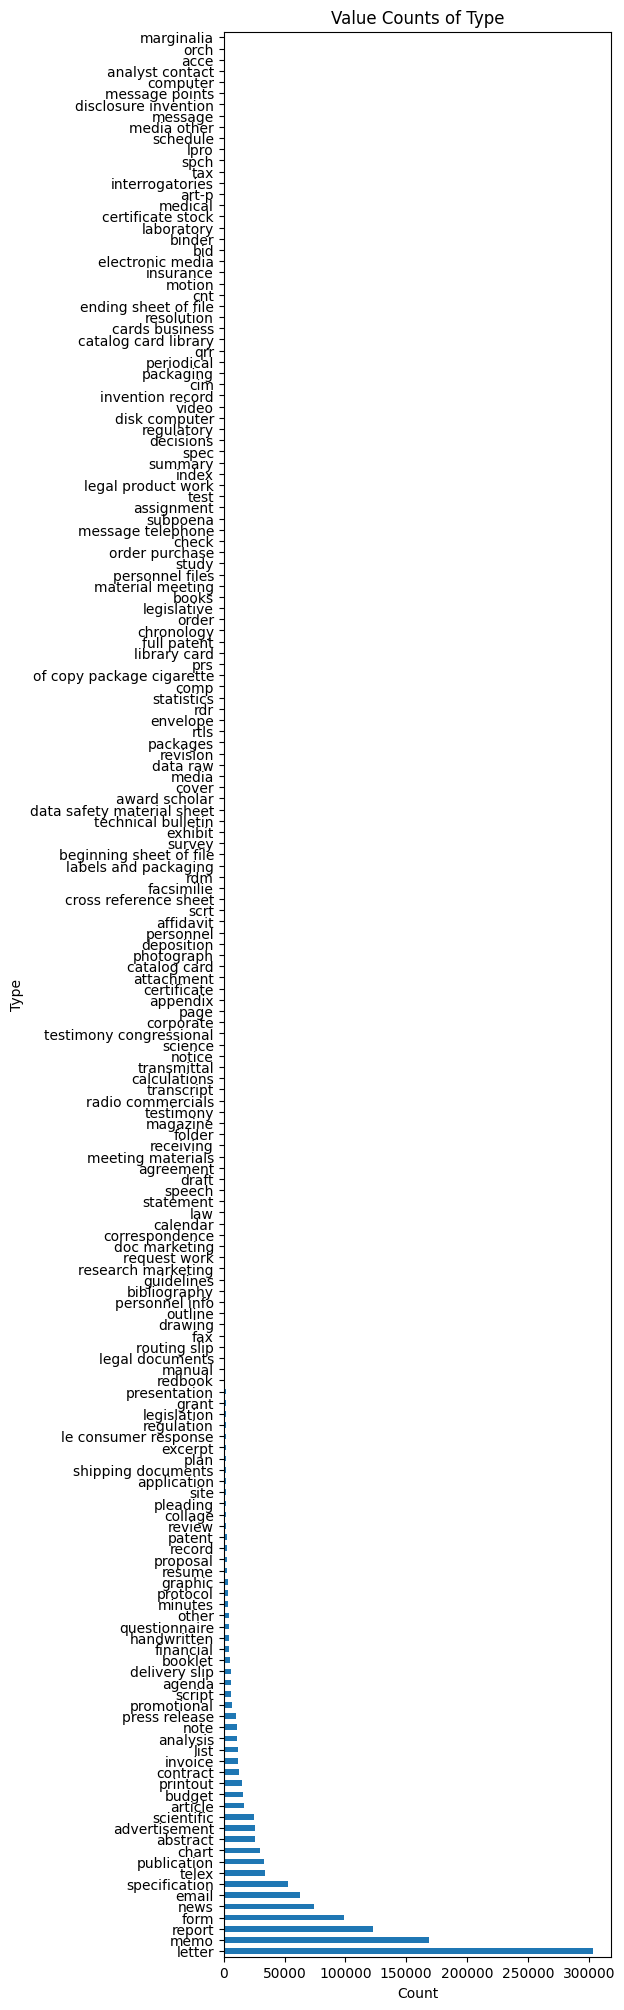

In [22]:
value_counts = df.type.value_counts()

plt.figure(figsize=(5, 25))  # Adjust the figure size as needed
value_counts.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Type')
plt.title('Value Counts of Type')
plt.show()

# Save file

In [20]:
data_list = df.to_dict('records')
np.save('preprocessed_cdip.npy', data_list, allow_pickle=True)

In [21]:
np.load('preprocessed_cdip.npy', allow_pickle=True)

array([{'image_path': '/common/datasets/cdip/images/imagesa/a/a/a/aaa01a00/0060213614.tif', 'text': 'MeE. MORANDIIM iixa2enmivrV cuewA os. ms. eaum. , o. amwscn. T February 5, 1976 E T0 Mrs. Theresa Fealcy, Corporate Media DepartmentF R V. Puleo, PointofPurchase and Graphic Arts, Purchasing . p CARLTON Filter 309heet Posters New Design mC, tPK. tiGwef. As per Mr. Sahrenbur. gs request we are furnishing you with estimated costs on G. RLmON Filter 30Sheet Posters, new design, captioned for identification Nobodys Lower than Carlton as follows: N, 361 30Sheet Posters 21us Sg6 overrun ! 3, 778, : 5. 06 cach 51, 444. 94 Pius esti: aated Air Freight on 4, 427Booters for Fobruari and Plarch Postings 9, 000. 00 Plus estimated eigbY via Cosnnon Carrierfor 3, 934 Pasters . or loril. 3, 500. 00Ahove pasters to be printod in three colors, red, black and aprinted vhite ba. ckjrnund. At thia tivme we have not recaiced our shipping instructions. Wemust havo instructions today so that our supplier can 

In [22]:
data_list[3]

{'image_path': '/common/datasets/cdip/images/imagesa/a/a/a/aaa02d00/71387821.tif',
 'text': 'CUNNINGHAM amp WALSH CHICAGO, INC. 875 NOR1H MIC. i iGAN AVFNUE CHICAG IP, 015, 10611 . 312 943940UAD COPY INSTRUCTIONSPlease advise us immediately, if instructions are not clear. DATE OF ORDER: CONTRACT NO: EDITION: L JADVERTISER: Brown amp Williamson Tobacco Corp. PRODUCT: POSITION: As per agreement with our Media Department Contract IMPORTANT This document is for ad copy instructions only and is not an insertion order. Our Media Contract is the Q1authorization for insertion date and size. If there is any discrepancy between our copy instructions and contract, notify theundersigned immediatelwINSERTION DATE: SPACE: AD. NO: HEADLINE: KEY NO: PUBLICATION: Plaoso be suro to bill all Production chargos if aay socb as safety nrolds, effsat conwrsiens, olc. , no Iator tban 70 days from data sf or. r Insortisnorder. Pleoso comply with this request or payment will not be raade. Send gcopies to repres

In [23]:
if data_list[3].get('key'):
    print('a')

In [13]:
df

image_path  \
0        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
1        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
2        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
3        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
4        /common/datasets/cdip/images/imagesa/a/a/a/aaa...   
...                                                    ...   
1284549  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   
1284550  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   
1284551  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   
1284552  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   
1284553  /common/datasets/cdip/images/imagesz/z/z/z/zzz...   

                                                      text     type  \
0        MeE. MORANDIIM iixa2enmivrV cuewA os. ms. eaum...     memo   
1        PROFS note for HREIF 3 Mar 1993 07: 40 Page 1 ...    telex   
2        7IMEFENABNANGE GregMoureLEFT and GiI de Ferran...  article   
3        CUNNINGHAM amp WALSH CHICAGO, INC. 875 NOR1H M...     form   
4        INBIFO Institut fir biologische Forschung KOIn...     form   
...                                                    ...      ...   
1284549  Business Ethics Introduction Page 1 of IBusine...     site   
1284550  Microbiological Associates5221 RIVER ROAD . BE...   letter   
1284551  MAR1391 THU M59 RKH PUBLIC RELATIONS FAX N0, 3...     form   
1284552  SITE VISIT AGENDATOBACCO INDUSTRY RESEARCH PRf...   agenda   
1284553  THE COUNCIL FOR TOBACCO RESEARCHU. S. A. , INC...   budget   

                                                       key  
0        carlton filter 30sheet posters new design, mar...  
1                                      phone call w lister  
2                                     penske serves notice  
3                                                      NaN  
4          general objectives and specifications p05005209  
...                                                    ...  
1284549                                    business ethics  
1284550                                                NaN  
1284551       fax cover sheet junk science column, d. post  
1284552  site visit agenda tobacco industry research pr...  
1284553  financial statement for the period 1192 to 123...  

[1284554 rows x 4 columns]